In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the dataset for churn 

In [4]:
df = pd.read_csv("new_variant_1.csv")

In [5]:
df['Status'] = df['Status'].apply(lambda x: 1 if x == 'yes' else 0)

# Modelling and Validation

#### Define target and features columns

In [6]:
y_column = ['Status'] # target variable
X_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 
             'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 
             'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 
             'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 
             'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',]

X = df[X_columns]
y = df[y_column]

### Definition of Train-Valid-Test Split
Train-Valid-Test split is a technique to evaluate the performance of your machine learning model — classification or regression alike. You take a given dataset and divide it into three subsets. A brief description of the role of each of these datasets is below.
#### Train Dataset
Set of data used for learning (by the model), that is, to fit the parameters to the machine learning model
#### Valid Dataset
Set of data used to provide an unbiased evaluation of a model fitted on the training dataset while tuning model hyperparameters.
Also play a role in other forms of model preparation, such as feature selection, threshold cut-off selection.
#### Test Dataset
Set of data used to provide an unbiased evaluation of a final model fitted on the training dataset.

A validation dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning model’s hyperparameters.

The validation dataset is different from the test dataset that is also held back from the training of the model, but is instead used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.

In [7]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)


(115669, 30)
(115669, 1)
(14459, 30)
(14459, 1)
(14459, 30)
(14459, 1)


In [8]:
models = { 'LogisticRegression' : LogisticRegression(class_weight='balanced'), 
          'KNeighborsClassifier' : KNeighborsClassifier(weights='distance'),
         }

In [9]:
classifiers = dict()
for name, model in models.items():
    print('training ',name)
    classifier = model
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print('test set metrics: \n', metrics.classification_report(y_test, y_pred))
    y_pred = classifier.predict(X_valid)
    print('validation set metrics: \n ', metrics.classification_report(y_valid, y_pred))
    classifiers[name] = classifier


training  LogisticRegression
test set metrics: 
               precision    recall  f1-score   support

           0       0.85      0.66      0.74     10895
           1       0.39      0.66      0.49      3564

    accuracy                           0.66     14459
   macro avg       0.62      0.66      0.62     14459
weighted avg       0.74      0.66      0.68     14459

validation set metrics: 
                precision    recall  f1-score   support

           0       0.85      0.67      0.75     10824
           1       0.40      0.65      0.49      3635

    accuracy                           0.66     14459
   macro avg       0.62      0.66      0.62     14459
weighted avg       0.74      0.66      0.68     14459

training  KNeighborsClassifier
test set metrics: 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     10895
           1       0.65      0.50      0.57      3564

    accuracy                           0.81     14459
 

# K-fold validation

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:



![title](image/k_fold.jpg)

In [10]:
from numpy import array
from sklearn.model_selection import KFold


# split train/test data
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)


# prepare cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# enumerate splits
for train, test in kfold.split(X_train):
    classifier = LogisticRegression(class_weight='balanced')
    classifier.fit(X_train.iloc[train], y_train.iloc[train])
    y_pred = classifier.predict(X_train.iloc[test])
    print('k-fold set metrics:\n ', metrics.classification_report(y_train.iloc[test], y_pred))

y_pred = classifier.predict(X_test)    
print('test set metrics:\n ', metrics.classification_report(y_test, y_pred))


k-fold set metrics:
                precision    recall  f1-score   support

           0       0.85      0.68      0.76     17456
           1       0.39      0.64      0.49      5678

    accuracy                           0.67     23134
   macro avg       0.62      0.66      0.62     23134
weighted avg       0.74      0.67      0.69     23134

k-fold set metrics:
                precision    recall  f1-score   support

           0       0.85      0.67      0.75     17394
           1       0.40      0.65      0.49      5740

    accuracy                           0.67     23134
   macro avg       0.62      0.66      0.62     23134
weighted avg       0.74      0.67      0.69     23134

k-fold set metrics:
                precision    recall  f1-score   support

           0       0.85      0.68      0.76     17395
           1       0.40      0.65      0.49      5739

    accuracy                           0.67     23134
   macro avg       0.63      0.66      0.63     23134
weighted

# Random permutations cross-validation

The ShuffleSplit iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets.

It is possible to control the randomness for reproducibility of the results by explicitly seeding the random_state pseudo random number generator.



In [11]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index, test_index in ss.split(X):
    classifier = LogisticRegression(class_weight='balanced')
    classifier.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = classifier.predict(X.iloc[test_index])
    print('k-fold set metrics:\n ', metrics.classification_report(y.iloc[test_index], y_pred))

k-fold set metrics:
                precision    recall  f1-score   support

           0       0.86      0.68      0.76     21817
           1       0.40      0.66      0.49      7101

    accuracy                           0.67     28918
   macro avg       0.63      0.67      0.63     28918
weighted avg       0.74      0.67      0.69     28918

k-fold set metrics:
                precision    recall  f1-score   support

           0       0.85      0.66      0.75     21844
           1       0.38      0.65      0.48      7074

    accuracy                           0.66     28918
   macro avg       0.62      0.65      0.61     28918
weighted avg       0.74      0.66      0.68     28918

k-fold set metrics:
                precision    recall  f1-score   support

           0       0.85      0.66      0.74     21876
           1       0.38      0.64      0.48      7042

    accuracy                           0.66     28918
   macro avg       0.61      0.65      0.61     28918
weighted

# Leave-One-Out cross-validator

Provides train/test indices to split data in train/test sets. Each sample is used once as a test set (singleton) while the remaining samples form the training set.

Note: LeaveOneOut() is equivalent to KFold(n_splits=n) and LeavePOut(p=1) where n is the number of samples.

Due to the high number of test sets (which is the same as the number of samples) this cross-validation method can be very costly. For large datasets one should favor KFold, ShuffleSplit or StratifiedKFold.

In [12]:
# from sklearn.model_selection import LeaveOneOut
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier

# print(X.shape, y.shape)
# # create loocv procedure
# cv = LeaveOneOut()
# # create model
# model = LogisticRegression(class_weight='balanced')
# # evaluate model
# scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# Group k-fold

GroupKFold is a variation of k-fold which ensures that the same group is not represented in both testing and training sets. For example if the data is obtained from different subjects with several samples per-subject and if the model is flexible enough to learn from highly person specific features it could fail to generalize to new subjects. GroupKFold makes it possible to detect this kind of overfitting situations.

Imagine you have three subjects, each with an associated number from 1 to 3:

![title](GroupKFold.png)

In [13]:
X['Credit_Score'].unique()

array([758, 552, 834, 587, 602, 864, 860, 863, 580, 788, 723, 501, 884,
       520, 773, 685, 846, 534, 629, 688, 668, 692, 620, 533, 518, 812,
       647, 683, 705, 701, 591, 889, 651, 716, 780, 799, 766, 868, 765,
       673, 876, 886, 772, 640, 798, 858, 543, 555, 603, 808, 519, 786,
       769, 556, 567, 632, 818, 584, 750, 838, 741, 820, 665, 783, 663,
       612, 739, 571, 870, 793, 804, 801, 711, 634, 764, 865, 593, 511,
       774, 644, 732, 586, 642, 872, 898, 734, 639, 506, 664, 670, 577,
       857, 653, 595, 787, 560, 613, 514, 867, 717, 619, 600, 524, 883,
       503, 887, 604, 648, 797, 806, 845, 815, 585, 729, 538, 791, 671,
       755, 760, 578, 836, 777, 667, 880, 568, 805, 590, 892, 540, 869,
       737, 831, 608, 803, 795, 674, 781, 545, 796, 660, 850, 851, 794,
       866, 611, 621, 862, 829, 848, 733, 700, 633, 702, 882, 686, 652,
       844, 649, 557, 761, 569, 523, 740, 638, 690, 616, 782, 601, 809,
       855, 768, 627, 854, 762, 746, 592, 697, 710, 522, 789, 69

In [31]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=7)
for train_index, test_index in gkf.split(X, y, groups=X['Credit_Score']):
    print('Uniq CreditScore for test \n',X.iloc[test_index]['Credit_Score'].unique())
    classifier = LogisticRegression(class_weight='balanced')
    classifier.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = classifier.predict(X.iloc[test_index])
    print('k-fold set metrics: \n', metrics.classification_report(y.iloc[test_index], y_pred))

Uniq CreditScore for test 
 [552 534 692 620 705 591 798 741 804 664 613 797 836 540 795 866 700 597
 800 625 763 715 572 856 547 618 630 589 811 583 666 588 730 570 720 722
 881 726 749 675 628 582 832 550 528 509 821 826 532 725 610 754 819 566
 891 841 507]
k-fold set metrics: 
               precision    recall  f1-score   support

           0       0.86      0.67      0.75     15509
           1       0.39      0.66      0.49      5058

    accuracy                           0.67     20567
   macro avg       0.63      0.66      0.62     20567
weighted avg       0.74      0.67      0.69     20567

Uniq CreditScore for test 
 [602 580 889 716 766 640 603 567 632 750 838 711 865 593 872 670 867 648
 585 791 667 568 590 831 781 794 829 768 746 697 680 718 713 626 879 743
 565 728 837 594 623 736 833 553 669 816 893 825 599 641 682 849 748 631
 542 859 650 521]
k-fold set metrics: 
               precision    recall  f1-score   support

           0       0.86      0.66      0.75     

# Validation metrics

## Classification metrics

#### Define target and features columns

In [15]:
y_column = ['Status'] # target variable
X_columns = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 
             'business_or_commercial', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 
             'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'property_value', 'construction_type', 
             'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type', 
             'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',]

X = df[X_columns]
y = df[y_column]

#### Train test set split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Confusion matrix

The confusion_matrix function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class (Wikipedia and other references may use different convention for axes).

By definition, entry  in a confusion matrix is the number of observations actually in group , but predicted to be in group . Here is an example:

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[[14456  7422]
 [ 2384  4656]]


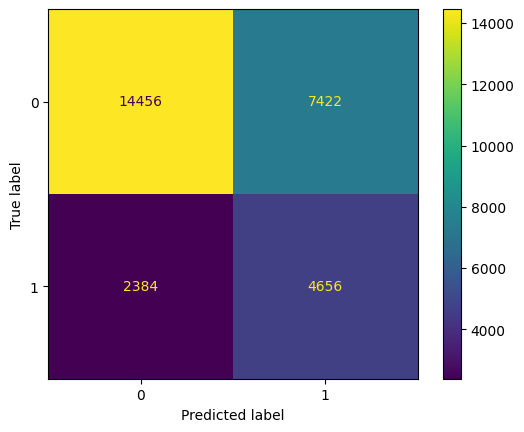

In [18]:
dt_classifier = LogisticRegression(class_weight='balanced')
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(conf_matrix)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

### Accuracy 

Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions to the total number of input samples.

It works well only if there are equal number of samples belonging to each class.
For example, consider that there are 98% samples of class A and 2% samples of class B in our training set. Then our model can easily get 98% training accuracy by simply predicting every training sample belonging to class A.
When the same model is tested on a test set with 60% samples of class A and 40% samples of class B, then the test accuracy would drop down to 60%. Classification Accuracy is great, but gives us the false sense of achieving high accuracy.
The real problem arises, when the cost of misclassification of the minor class samples are very high. If we deal with a rare but fatal disease, the cost of failing to diagnose the disease of a sick person is much higher than the cost of sending a healthy person to more tests

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
dt_classifier = LogisticRegression(class_weight='balanced')
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
metrics.accuracy_score(y_test, y_pred)


0.6609032436544713

### Precision
It is the number of correct positive results divided by the number of positive results predicted by the classifier.

![title](image/precission.gif)

In [21]:
from sklearn.metrics import precision_score

In [22]:
dt_classifier = LogisticRegression(class_weight='balanced')
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
metrics.precision_score(y_test, y_pred)


np.float64(0.3854942871336314)

### Recall
It is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).

![title](image/recall.gif)

In [23]:
from sklearn.metrics import recall_score

In [24]:
dt_classifier = LogisticRegression(class_weight='balanced')
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
metrics.recall_score(y_test, y_pred)


np.float64(0.6613636363636364)

### F1 Score
F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0, 1]. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).
High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. The greater the F1 Score, the better is the performance of our model. Mathematically, it can be expressed as :

![title](image/f1.gif)

In [25]:
from sklearn.metrics import f1_score

In [26]:
dt_classifier = LogisticRegression(class_weight='balanced')
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
metrics.f1_score(y_test, y_pred)


np.float64(0.4870802385186735)

### Area Under Curve(AUC)
Area Under Curve(AUC) is one of the most widely used metrics for evaluation. It is used for binary classification problem. AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. Before defining AUC, let us understand two basic terms.

The function roc_curve computes the receiver operating characteristic curve, or ROC curve. Quoting Wikipedia :

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

This function requires the true binary value and the target scores, which can either be probability estimates of the positive class, confidence values, or binary decisions. Here is a small example of how to use the roc_curve function:

In [27]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

dt_classifier = LogisticRegression(class_weight='balanced')
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


In [28]:
roc_auc

np.float64(0.6610593664037764)

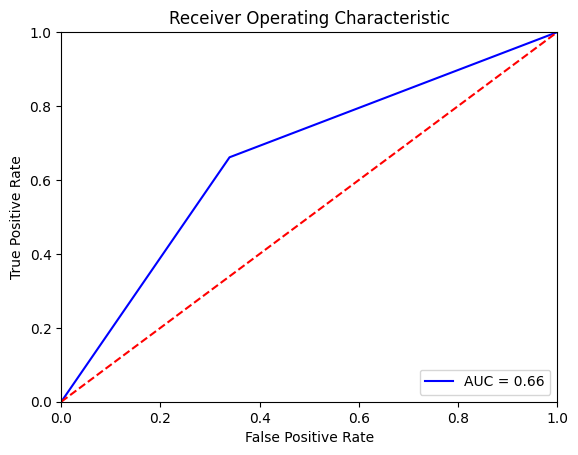

In [29]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### The classification_report function builds a text report showing the main classification metrics. 

In [30]:
dt_classifier = LogisticRegression(class_weight='balanced')
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75     21878
           1       0.39      0.66      0.49      7040

    accuracy                           0.66     28918
   macro avg       0.62      0.66      0.62     28918
weighted avg       0.74      0.66      0.68     28918

